# Outline
- Pre-processing
- Additive model
- Dendrogram/PC
- Multiplicitive model

# Set Environment

In [92]:
source("pilot_config.R")
source("pilot_util.R")

# Import Data & Create DESeq from Count Data

In [93]:
# import RData (annomapres0, annogenecnts0)
attach(file.path(OUTDIR, "HTS-Pilot-Annotated-STAR-counts.RData"))

The following objects are masked from file:/home/jovyan/work/scratch/analysis_output/out/HTS-Pilot-Annotated-STAR-counts.RData (pos = 3):

    annogenecnts, annogenecnts0, annomapres, annomapres0, mtdf

The following objects are masked from file:/home/jovyan/work/scratch/analysis_output/out/HTS-Pilot-Annotated-STAR-counts.RData (pos = 5):

    annogenecnts, annogenecnts0, annomapres, annomapres0, mtdf



Lets review what we have created before

In [94]:
# metadata
head(annomapres0, 3)

Label,Strain,Media,experiment_person,libprep_person,enrichment_method,prob.gene,prob.nofeat,prob.unique,depth
1_MA_J,H99,YPD,expA,prepB,MA,0.9641456,0.008161923,0.9723075,2493464
1_RZ_J,H99,YPD,expA,prepB,RZ,0.6689001,0.217095621,0.8859957,3541358
10_MA_C,mar1d,YPD,expA,prepA,MA,0.9618651,0.009818573,0.9716837,3282785


In [95]:
# count matrix
head(annogenecnts0, 3)

gene,1_MA_J,1_RZ_J,10_MA_C,10_RZ_C,11_MA_J,11_RZ_J,12_MA_P,12_RZ_P,13_MA_J,⋯,4_RZ_P,4_TOT_P,40_MA_J,40_RZ_J,45_MA_P,45_RZ_P,47_MA_P,47_RZ_P,9_MA_C,9_RZ_C
CNAG_00001,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CNAG_00002,265,204,269,76,130,92,205,64,308,⋯,51,13,519,235,410,122,534,112,217,106
CNAG_00003,112,40,171,24,124,18,150,34,221,⋯,11,8,218,53,232,46,240,41,128,35


Prepare columnData DataFrame and countData (matrix object)
- columnData --- metadata
- countData  --- count matrix

In [96]:
# columnData --- metadata
annomapres0 %>%
    dplyr::filter(enrichment_method == "RZ")  %>%
    DataFrame ->
    columnData
rownames(columnData) <- columnData[["Label"]]

head(columnData[, c("Label", "Strain", "Media")], 3)

DataFrame with 3 rows and 3 columns
              Label   Strain    Media
        <character> <factor> <factor>
1_RZ_J       1_RZ_J      H99      YPD
10_RZ_C     10_RZ_C    mar1d      YPD
11_RZ_J     11_RZ_J    mar1d      YPD

In [97]:
# countData  --- count matrix
annogenecnts0 %>%
    dplyr::select(dput(as.character(c("gene", columnData[["Label"]])))) %>%
    as.data.frame %>%
    column_to_rownames("gene") %>%
    as.matrix ->
    countData

head(countData, 3)

c("gene", "1_RZ_J", "10_RZ_C", "11_RZ_J", "12_RZ_P", "13_RZ_J", 
"14_RZ_C", "15_RZ_C", "16_RZ_P", "2_RZ_C", "21_RZ_C", "22_RZ_C", 
"23_RZ_J", "24_RZ_J", "26_RZ_C", "27_RZ_P", "3_RZ_J", "35_RZ_P", 
"36_RZ_J", "38_RZ_P", "4_RZ_P", "40_RZ_J", "45_RZ_P", "47_RZ_P", 
"9_RZ_C")


,1_RZ_J,10_RZ_C,11_RZ_J,12_RZ_P,13_RZ_J,14_RZ_C,15_RZ_C,16_RZ_P,2_RZ_C,21_RZ_C,⋯,27_RZ_P,3_RZ_J,35_RZ_P,36_RZ_J,38_RZ_P,4_RZ_P,40_RZ_J,45_RZ_P,47_RZ_P,9_RZ_C
CNAG_00001,0,0,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CNAG_00002,204,76,92,64,230,182,200,129,168,124,⋯,43,107,150,109,95,51,235,122,112,106
CNAG_00003,40,24,18,34,56,53,54,40,40,41,⋯,9,24,26,43,43,11,53,46,41,35


### Make DESeq object on the basis of the counts

The design option allows you to specify an additive or a multiplicitive model

Additive model

In [98]:
dds_add <- DESeqDataSetFromMatrix(
    countData,                       # Count matrix
    columnData,                      # metadata
    ~ Media + Strain) # design formula

Multiplicitive model

In [99]:
dds_mult <- DESeqDataSetFromMatrix(
    countData,                       # Count matrix
    columnData,                      # metadata
    ~ Media + Strain + Media:Strain) # design formula

In the following demonstration, we will use the additive model. The multiplicitive model will be illustrated in the appendix below.

In [100]:
dds <- dds_add

# Inspect object & Slots of an S4 class

Let's has a look at the object we have created.

In [101]:
dds

class: DESeqDataSet 
dim: 8497 24 
metadata(1): version
assays(1): counts
rownames(8497): CNAG_00001 CNAG_00002 ... ENSRNA049551964
  ENSRNA049551993
rowData names(0):
colnames(24): 1_RZ_J 10_RZ_C ... 47_RZ_P 9_RZ_C
colData names(10): Label Strain ... prob.unique depth

see the class of dds object

In [102]:
class(dds)

[1] "DESeqDataSet"
attr(,"package")
[1] "DESeq2"

DESeqDataSet is a S4 object. Recall that a S4 object was taught when introducing bioconductor. Note that S4 objects allow users to wrap up multiple elements into a single variables where each element is called a slot.

In [103]:
slotNames(dds)

[1] "design"             "dispersionFunction" "rowRanges"         
[4] "colData"            "assays"             "NAMES"             
[7] "elementMetadata"    "metadata"

The metadata (columnData) is stored in the slot `colData`

In [104]:
dds@colData %>% as.data.frame %>% head(3)

,Label,Strain,Media,experiment_person,libprep_person,enrichment_method,prob.gene,prob.nofeat,prob.unique,depth
1_RZ_J,1_RZ_J,H99,YPD,expA,prepB,RZ,0.6689001,0.2170956,0.8859957,3541358
10_RZ_C,10_RZ_C,mar1d,YPD,expA,prepA,RZ,0.7497438,0.2006517,0.9503955,1742594
11_RZ_J,11_RZ_J,mar1d,YPD,expA,prepB,RZ,0.7030020,0.1955472,0.8985491,2621913


The design formula is stored in the slot `design`. The design holds the R formula which expresses how the counts depend on the variables in colData.

In [105]:
dds@design

~Media + Strain

The first thing you may want to do is **have a look at the raw counts** you have imported. The `DESeq2::counts` function extracts a matrix of counts (with the genes along the rows and samples along the columns). Let us first verify the dimension of this matrix.

In [106]:
dim(counts(dds))

[1] 8497   24

In [107]:
head(counts(dds),3)

,1_RZ_J,10_RZ_C,11_RZ_J,12_RZ_P,13_RZ_J,14_RZ_C,15_RZ_C,16_RZ_P,2_RZ_C,21_RZ_C,⋯,27_RZ_P,3_RZ_J,35_RZ_P,36_RZ_J,38_RZ_P,4_RZ_P,40_RZ_J,45_RZ_P,47_RZ_P,9_RZ_C
CNAG_00001,0,0,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CNAG_00002,204,76,92,64,230,182,200,129,168,124,⋯,43,107,150,109,95,51,235,122,112,106
CNAG_00003,40,24,18,34,56,53,54,40,40,41,⋯,9,24,26,43,43,11,53,46,41,35


This slot returns gene specific information (it will be populated later)

In [108]:
dds@dispersionFunction

function () 
NULL
<bytecode: 0xb6d0760>

# Estimate Size Factors and Dispersion Parameters

You recall that DESeq requires that  we have estimates for sample specific size factors and gene specific dispersion factors. More specifically, recall that DESeq models the count $K_{ij}$ (gene $i$, sample $j$) as negative binomial with mean $\mu_{ij}$ and dispersion parameter $\alpha_i$. Here $\mu_{ij}=s_j q_{ij}$ where $\log_2(q_{ij}) = \beta_{0i} + \beta_{1i} z_j$. Here $s_j$ is the sample $j$ specific size factor.

**Summarize of notation**
- $K_{ij}$ denotes the observed **number of reads** mapped to gene $i$ for sample $j$
- $K_{ij}$ follows a **negative binomial distribution** with
    - **Mean** $\mu_{ij}$
    - **Dispersion parameter** $\alpha_i$
- Modelling
    - $K_{ij} \sim NB(\mu_{ij}, \alpha_i)$
    - $\mu_{ij} = s_{j}q_{ij}$
        - $s_j$ is sample $j$ specific normalization constant
    - $\log_2(q_{ij}) = \beta_{0i} + \beta_{1i} z_j$

## 01 Size Factors
 We begin by estimating the size factors $s_1,\ldots,s_n$:

In [109]:
dds <- estimateSizeFactors(dds)

Now, compare the dds object to that of before applying the estimateSizeFactors() function. What has changed? What remains unchanged?

In [110]:
dds

class: DESeqDataSet 
dim: 8497 24 
metadata(1): version
assays(1): counts
rownames(8497): CNAG_00001 CNAG_00002 ... ENSRNA049551964
  ENSRNA049551993
rowData names(0):
colnames(24): 1_RZ_J 10_RZ_C ... 47_RZ_P 9_RZ_C
colData names(11): Label Strain ... depth sizeFactor

Note that there is a **sizeFactor** added to **colData**. Let's look at it more carefully

```
> dds # (before estimateSizeFactors)
class: DESeqDataSet 
dim: 8497 24 
metadata(1): version
assays(1): counts
rownames(8497): CNAG_00001 CNAG_00002 ... ENSRNA049551964 ENSRNA049551993
rowData names(0):
colnames(24): 1_RZ_J 10_RZ_C ... 47_RZ_P 9_RZ_C
colData names(10): Label Strain ... prob.unique depth

> dds # (after estimateSizeFactors)
class: DESeqDataSet 
dim: 8497 24 
metadata(1): version
assays(1): counts
rownames(8497): CNAG_00001 CNAG_00002 ... ENSRNA049551964 ENSRNA049551993
rowData names(0):
colnames(24): 1_RZ_J 10_RZ_C ... 47_RZ_P 9_RZ_C
colData names(11): Label Strain ... depth sizeFactor <------ 
```

You can also get the size factors directly

In [111]:
sizeFactors(dds)

1_RZ_J   10_RZ_C   11_RZ_J   12_RZ_P   13_RZ_J   14_RZ_C   15_RZ_C   16_RZ_P 
1.3586026 0.8098675 1.1175159 0.7259843 1.4931353 1.2728063 1.4292963 0.8120792 
   2_RZ_C   21_RZ_C   22_RZ_C   23_RZ_J   24_RZ_J   26_RZ_C   27_RZ_P    3_RZ_J 
1.1701733 1.2251707 2.1685296 1.4819784 1.2452600 1.2247452 0.3038866 0.8550453 
  35_RZ_P   36_RZ_J   38_RZ_P    4_RZ_P   40_RZ_J   45_RZ_P   47_RZ_P    9_RZ_C 
0.9145604 1.1035045 0.6679411 0.3079857 1.6114054 0.8951536 0.9487772 1.2447085

 It is preferable to limit the number of decimal places. Next show the size factors rounded to 3 decimal places

In [112]:
round(sizeFactors(dds),3)

1_RZ_J 10_RZ_C 11_RZ_J 12_RZ_P 13_RZ_J 14_RZ_C 15_RZ_C 16_RZ_P  2_RZ_C 21_RZ_C 
  1.359   0.810   1.118   0.726   1.493   1.273   1.429   0.812   1.170   1.225 
22_RZ_C 23_RZ_J 24_RZ_J 26_RZ_C 27_RZ_P  3_RZ_J 35_RZ_P 36_RZ_J 38_RZ_P  4_RZ_P 
  2.169   1.482   1.245   1.225   0.304   0.855   0.915   1.104   0.668   0.308 
40_RZ_J 45_RZ_P 47_RZ_P  9_RZ_C 
  1.611   0.895   0.949   1.245

Now that the size factors have been estimated, we can get "normalized" counts. Here we print three data frames together to easily compare them.

In [113]:
# original count
head(counts(dds),3)

# normalized count
head(counts(dds, normalize = TRUE), 3)

# normalized manually using size factors
counts(dds)[1:3,] %>% 
    apply(., 1, function(row){row / sizeFactors(dds)}) %>%
    t

,1_RZ_J,10_RZ_C,11_RZ_J,12_RZ_P,13_RZ_J,14_RZ_C,15_RZ_C,16_RZ_P,2_RZ_C,21_RZ_C,⋯,27_RZ_P,3_RZ_J,35_RZ_P,36_RZ_J,38_RZ_P,4_RZ_P,40_RZ_J,45_RZ_P,47_RZ_P,9_RZ_C
CNAG_00001,0,0,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CNAG_00002,204,76,92,64,230,182,200,129,168,124,⋯,43,107,150,109,95,51,235,122,112,106
CNAG_00003,40,24,18,34,56,53,54,40,40,41,⋯,9,24,26,43,43,11,53,46,41,35


,1_RZ_J,10_RZ_C,11_RZ_J,12_RZ_P,13_RZ_J,14_RZ_C,15_RZ_C,16_RZ_P,2_RZ_C,21_RZ_C,⋯,27_RZ_P,3_RZ_J,35_RZ_P,36_RZ_J,38_RZ_P,4_RZ_P,40_RZ_J,45_RZ_P,47_RZ_P,9_RZ_C
CNAG_00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.231407,0.00000,0.00000,⋯,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
CNAG_00002,150.15429,93.84251,82.32545,88.15618,154.03828,142.99112,139.92900,158.851505,143.56847,101.21039,⋯,141.50014,125.13957,164.01322,98.77622,142.22812,165.59213,145.83543,136.28946,118.04668,85.16050
CNAG_00003,29.44202,29.63448,16.10715,46.83297,37.50497,41.64027,37.78083,49.256281,34.18297,33.46473,⋯,29.61631,28.06869,28.42896,38.96677,64.37694,35.71595,32.89054,51.38783,43.21352,28.11903


,1_RZ_J,10_RZ_C,11_RZ_J,12_RZ_P,13_RZ_J,14_RZ_C,15_RZ_C,16_RZ_P,2_RZ_C,21_RZ_C,⋯,27_RZ_P,3_RZ_J,35_RZ_P,36_RZ_J,38_RZ_P,4_RZ_P,40_RZ_J,45_RZ_P,47_RZ_P,9_RZ_C
CNAG_00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.231407,0.00000,0.00000,⋯,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
CNAG_00002,150.15429,93.84251,82.32545,88.15618,154.03828,142.99112,139.92900,158.851505,143.56847,101.21039,⋯,141.50014,125.13957,164.01322,98.77622,142.22812,165.59213,145.83543,136.28946,118.04668,85.16050
CNAG_00003,29.44202,29.63448,16.10715,46.83297,37.50497,41.64027,37.78083,49.256281,34.18297,33.46473,⋯,29.61631,28.06869,28.42896,38.96677,64.37694,35.71595,32.89054,51.38783,43.21352,28.11903


**Exercise:** How do you get the raw counts for gene  "GeneID: CNAG_05845"?

In [114]:
counts(dds, normalize = TRUE)["CNAG_05845",]

1_RZ_J  10_RZ_C  11_RZ_J  12_RZ_P  13_RZ_J  14_RZ_C  15_RZ_C  16_RZ_P 
607.9777 554.4117 614.7563 586.7896 548.5102 519.3249 518.4370 535.6621 
  2_RZ_C  21_RZ_C  22_RZ_C  23_RZ_J  24_RZ_J  26_RZ_C  27_RZ_P   3_RZ_J 
587.9471 613.7920 610.0908 570.8585 595.0565 658.0961 602.1983 702.8867 
 35_RZ_P  36_RZ_J  38_RZ_P   4_RZ_P  40_RZ_J  45_RZ_P  47_RZ_P   9_RZ_C 
566.3923 572.7208 516.5126 668.8623 554.1746 656.8705 582.8555 543.9025

**Exercise:** Get a summary (mean, median, quantiles etc ) of the size factors

In [115]:
summary(sizeFactors(dds))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3039  0.8443  1.1438  1.0995  1.2943  2.1685 

Before going to the next step, let's look at the dispersionFunction slot

In [116]:
# still empty
dds@dispersionFunction

function () 
NULL
<bytecode: 0xb6d0760>

## 02 Dispersion Parameters
Next, we get the dispersion factors $\alpha_1,\ldots,\alpha_{m}$

In [117]:
dds <- estimateDispersions(dds)

gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


Now inspect the dds object again and note that the rowRanges slot has extra information ("metadata column names(0):" before versus "column names(9): baseMean baseVar ... dispOutlier dispMAP")
- before: 
    - `metadata column names(0):`
- after:  
    - `column names(9): baseMean baseVar ...`

In [118]:
dds

class: DESeqDataSet 
dim: 8497 24 
metadata(1): version
assays(2): counts mu
rownames(8497): CNAG_00001 CNAG_00002 ... ENSRNA049551964
  ENSRNA049551993
rowData names(9): baseMean baseVar ... dispOutlier dispMAP
colnames(24): 1_RZ_J 10_RZ_C ... 47_RZ_P 9_RZ_C
colData names(11): Label Strain ... depth sizeFactor

Can you notice the difference?
```
> dds (before dispersion)
class: DESeqDataSet 
dim: 8497 24 
metadata(1): version
assays(1): counts
rownames(8497): CNAG_00001 CNAG_00002 ... ENSRNA049551964 ENSRNA049551993
rowData names(0):
colnames(24): 1_RZ_J 10_RZ_C ... 47_RZ_P 9_RZ_C
colData names(11): Label Strain ... depth sizeFactor

> dds (after dispersion)
class: DESeqDataSet 
dim: 8497 24 
metadata(1): version
assays(2): counts mu
rownames(8497): CNAG_00001 CNAG_00002 ... ENSRNA049551964 ENSRNA049551993
rowData names(9): baseMean baseVar ... dispOutlier dispMAP <------
colnames(24): 1_RZ_J 10_RZ_C ... 47_RZ_P 9_RZ_C
colData names(11): Label Strain ... depth sizeFactor
```

Note that the dispersionfunction slot is now populated

In [119]:
dds@dispersionFunction

function (q) 
coefs[1] + coefs[2]/q
<bytecode: 0x144f7dc0>
<environment: 0x18022850>
attr(,"coefficients")
asymptDisp  extraPois 
0.06527928 0.79851313 
attr(,"fitType")
[1] "parametric"
attr(,"varLogDispEsts")
[1] 1.374997
attr(,"dispPriorVar")
[1] 1.27508

We can extract the gene specific dispersion factors using dispersions(). Note that there will be one number per gene. We look at the first four genes (rounded to 4 decimal places)

In [120]:
alphas <- dispersions(dds)

Verify that the number of dispersion factors equals the number of genes

In [121]:
# number of disperion factors
length(alphas)

[1] 8497

In [122]:
# number of genes
nrow(dds)

[1] 8497

Print the dispersion factors for the first four genes rounded to four decimal points

In [123]:
round(alphas[1:4], 4)

[1] 24.0000  0.0179  0.0503  0.0112

Extract the metadata using mcols() for the first four genes

| Terms       | Description                                   |
|-------------|-----------------------------------------------|
| baseMean    |     mean of normalized counts for all samples |
| baseVar     | variance of normalized counts for all samples |
| allZero     |                all counts for a gene are zero |
| dispGeneEst |             gene-wise estimates of dispersion |
| dispFit     |                   fitted values of dispersion |
| dispersion  |                  final estimate of dispersion |
| dispIter    |                          number of iterations |
| dispOut     |                 dispersion flagged as outlier |
| dispMAP     |                 maximum a posteriori estimate |


In [124]:
mcols(dds)[1:4,] %>% as.data.frame

baseMean,baseVar,allZero,dispGeneEst,dispFit,dispersion,dispIter,dispOutlier,dispMAP
0.07052287,6.998486e-02,FALSE,0.000000010,11.38803286,24.00000000,9,FALSE,24.00000000
126.11152427,7.060125e+02,FALSE,0.013575482,0.07161108,0.01788340,9,FALSE,0.01788340
35.02318064,1.125921e+02,FALSE,0.045126093,0.08807884,0.05033664,9,FALSE,0.05033664
225.68281237,2.783750e+03,FALSE,0.008293503,0.06881749,0.01121072,10,FALSE,0.01121072


**Exercise:** Provide statistical summaries of the dispersion factors

In [125]:
summary(dispersions(dds))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0019  0.0206  0.0449  0.2520  0.1030 24.0000     347 

**Exercise:** Summarize the dispersion factors using a box plot (may want to log transform)

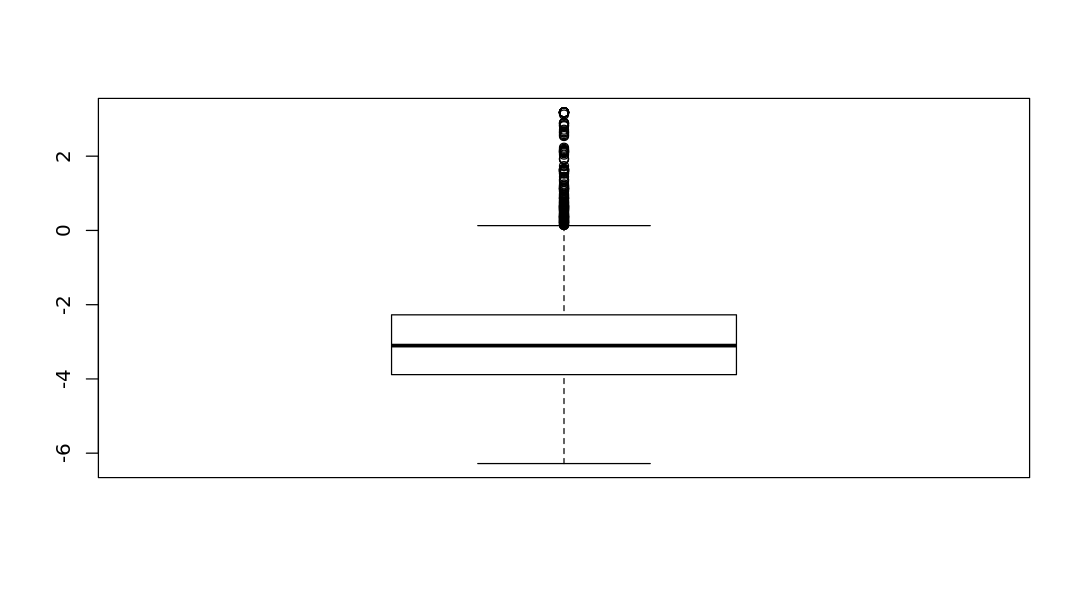

In [126]:
boxplot(log(dispersions(dds)))

# Differential Expression Analysis
We can now conduct a differential expression analysis using the DESeq() function. Keep in mind that to get to this step, we first estimated the size factors and then the dispersion parameters.

In [127]:
ddsDE <- DESeq(dds)

using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


Note that currently, the model we have is an additive model, which does not include the interaction term of `Media` and `Strain`

In [128]:
design(dds)

~Media + Strain

We can get the results for the differential expression analysis using results(). Here, we can compare two group of samples specified by the contrast. (If not, the default contrast would be the last term in your additive model `design(dds)`).

In [129]:
# compare two Media
myres_media <- results(ddsDE, contrast = c("Media", "YPD", "TC"))

In [130]:
# compare two Strains
myres_strain <- results(ddsDE, contrast = c("Strain", "H99", "mar1d"))

Let's look at the results for the first four genes

In [131]:
# first four genes
myres_strain[1:4,]

log2 fold change (MLE): Strain H99 vs mar1d 
Wald test p-value: Strain H99 vs mar1d 
DataFrame with 4 rows and 6 columns
               baseMean log2FoldChange      lfcSE        stat       pvalue
              <numeric>      <numeric>  <numeric>   <numeric>    <numeric>
CNAG_00001   0.07052287     0.26798424 3.00317536  0.08923363 9.288962e-01
CNAG_00002 126.11152427     0.44004098 0.09524333  4.62017631 3.834141e-06
CNAG_00003  35.02318064     0.12269499 0.16671498  0.73595662 4.617571e-01
CNAG_00004 225.68281237    -0.06055314 0.07445571 -0.81327733 4.160591e-01
                   padj
              <numeric>
CNAG_00001 9.637344e-01
CNAG_00002 5.989529e-05
CNAG_00003 6.341189e-01
CNAG_00004 5.958552e-01

 You can get the descriptions for the columns from the DE analysis

In [132]:
data.frame(desc = mcols(myres_strain)$description) 

desc
mean of normalized counts for all samples
log2 fold change (MLE): Strain H99 vs mar1d
standard error: Strain H99 vs mar1d
Wald statistic: Strain H99 vs mar1d
Wald test p-value: Strain H99 vs mar1d
BH adjusted p-values


manually calculate the baseMean to see if a gene

In [133]:
t(counts(dds, normalize = TRUE)["CNAG_00001",])

1_RZ_J,10_RZ_C,11_RZ_J,12_RZ_P,13_RZ_J,14_RZ_C,15_RZ_C,16_RZ_P,2_RZ_C,21_RZ_C,⋯,27_RZ_P,3_RZ_J,35_RZ_P,36_RZ_J,38_RZ_P,4_RZ_P,40_RZ_J,45_RZ_P,47_RZ_P,9_RZ_C
0,0,0,0,0,0,0,1.231407,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [134]:
mean(counts(dds, normalize = TRUE)["CNAG_00001",])

[1] 0.07052287

##  P-values

Here we will play with the p-value of the results. Below we demonstrate how the p-value is adjusted using BH method

One can extract the unadjusted p-values as follows

In [135]:
pvalues <- myres_strain$pvalue
length(pvalues)
pvalues[1:4]

[1] 8497

[1] 9.288962e-01 3.834141e-06 4.617571e-01 4.160591e-01

The BH adjusted p-values can be extracted as

In [136]:
adjp <- myres_strain$padj
length(adjp)
adjp[1:4]

[1] 8497

[1] 9.637344e-01 5.989529e-05 6.341189e-01 5.958552e-01

Calculate BH adjusted P-values by "hand" using the p.adjust() function. Note that you will not replicate the results you get under the padj column (when looking at the first four rows)

In [137]:
pvalues <- myres_strain$pvalue
BH <- p.adjust(pvalues,"BH")
data.frame(BH = BH[1:4], adjp = adjp[1:4])

BH,adjp
9.637344e-01,9.637344e-01
5.989529e-05,5.989529e-05
6.341189e-01,6.341189e-01
5.958552e-01,5.958552e-01


The DESeq2::results function applies "independent" filtering. This is enabled by default. Let's disable and then reexamine the adjusted P-values

In [138]:
myres1 <- results(ddsDE, independentFiltering = FALSE)

In [139]:
myres1

log2 fold change (MLE): Strain mar1d vs H99 
Wald test p-value: Strain mar1d vs H99 
DataFrame with 8497 rows and 6 columns
                    baseMean log2FoldChange      lfcSE        stat       pvalue
                   <numeric>      <numeric>  <numeric>   <numeric>    <numeric>
CNAG_00001        0.07052287    -0.26798424 3.00317536 -0.08923363 9.288962e-01
CNAG_00002      126.11152427    -0.44004098 0.09524333 -4.62017631 3.834141e-06
CNAG_00003       35.02318064    -0.12269499 0.16671498 -0.73595662 4.617571e-01
CNAG_00004      225.68281237     0.06055314 0.07445571  0.81327733 4.160591e-01
CNAG_00005       96.90603987    -0.51329445 0.23707350 -2.16512793 3.037789e-02
...                      ...            ...        ...         ...          ...
ENSRNA049551862            0             NA         NA          NA           NA
ENSRNA049551899            0             NA         NA          NA           NA
ENSRNA049551942            0             NA         NA          NA          

 We can now replicate the results

In [140]:
pvalues1 <- myres1$pvalue
BH1 <- p.adjust(pvalues1[!is.na(pvalues)], "BH")
data.frame(
    BH   = BH1[1:4],
    adjp = myres1$padj[1:4])

BH,adjp
9.637344e-01,9.637344e-01
5.989529e-05,5.989529e-05
6.341189e-01,6.341189e-01
5.958552e-01,5.958552e-01


##  Subset and reorder the results

In [141]:
class(myres_strain)

[1] "DESeqResults"
attr(,"package")
[1] "DESeq2"

In [142]:
summary(myres_strain, 0.05)


out of 8150 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 881, 11% 
LFC < 0 (down)   : 1338, 16% 
outliers [1]     : 183, 2.2% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



 You can sort the results by say the unadjusted P-values

In [143]:
results(ddsDE, contrast = c("Strain", "H99", "mar1d"), tidy = TRUE) %>%
    arrange(padj) %>% 
    head(4)

row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
CNAG_03398,79.8140,-1.9791305,0.13518105,-14.64059,1.547180e-48,1.232638e-44
CNAG_03623,210.3915,-1.0625362,0.08074884,-13.15853,1.520117e-39,6.055386e-36
CNAG_00727,495.6216,0.7518105,0.05800803,12.96045,2.050298e-38,5.444908e-35
CNAG_02587,157.7568,-1.2178205,0.09880546,-12.32544,6.608408e-35,1.316230e-31


To get the list of genes with unadjusted P-values < 0.00001 and absolute log2 FC of more than 4

In [144]:
results(ddsDE, contrast = c("Strain", "H99", "mar1d"), tidy = TRUE) %>%
    filter(padj < 0.00001) %>%
    filter(abs(log2FoldChange) > 4)

row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
CNAG_04459,227.0682,-4.442127,0.387609,-11.46033,2.087223e-30,2.375558e-27


The P-values for the four top genes are beyond machine precision. You can use the format.pval() function to properly format the P-values. PLEASE promote ending the practice of publishing P-values below machine precision.  (that would be akin to stating the weight of an object that weighs less than one pound with a scale whose minimum weight spec is 1 pound).

In [145]:
results(ddsDE, contrast = c("Strain", "H99", "mar1d"), tidy = TRUE) %>%
    filter(padj < 0.00001) %>%
    filter(abs(log2FoldChange) > 4) %>%
    mutate(pval = format.pval(pvalue))

row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,pval
CNAG_04459,227.0682,-4.442127,0.387609,-11.46033,2.087223e-30,2.375558e-27,< 2.22e-16


Let's look at a volcano plot

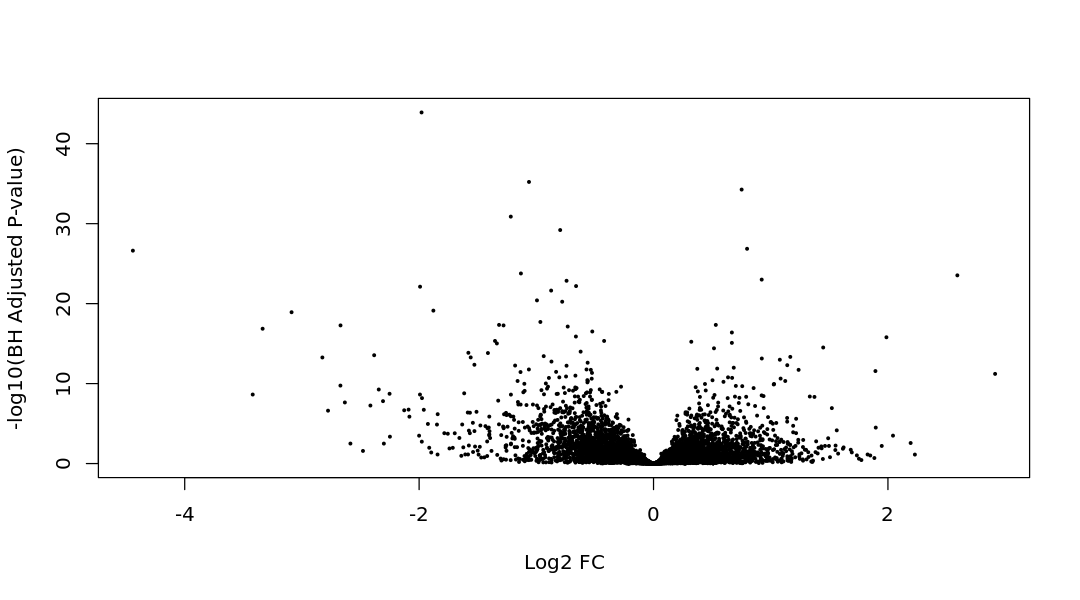

In [146]:
plot(myres_strain$log2FoldChange,
     -log10(myres_strain$padj),
     pch  = 19, 
     cex  = 0.3,
     xlab = "Log2 FC",
     ylab = "-log10(BH Adjusted P-value)")

Exercise: Annotate the hits with adjusted P-values < 0.05 and absolute log2 FC greater than 2 in red

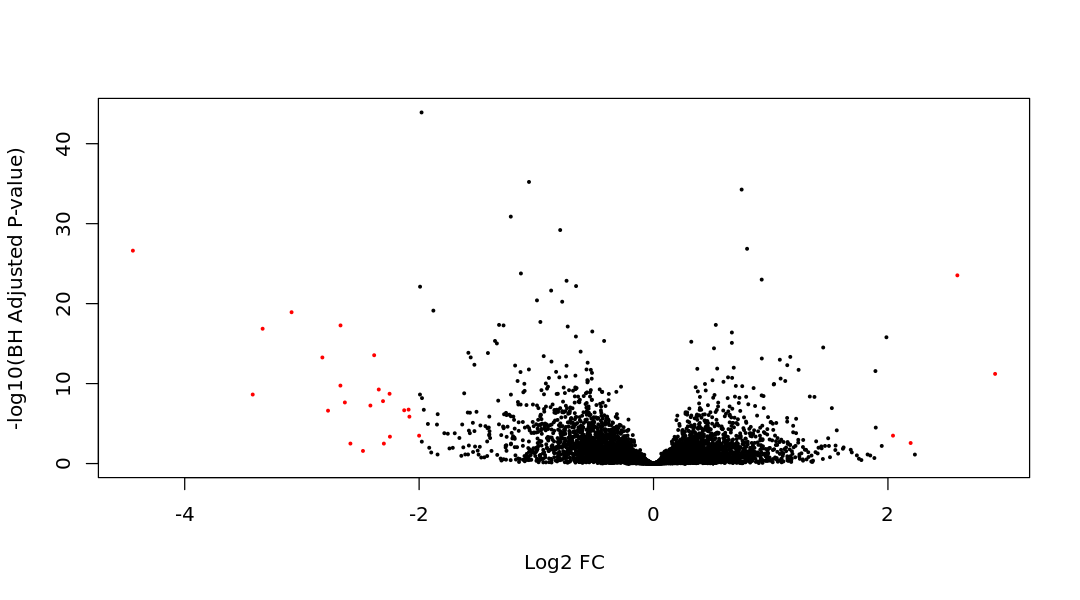

In [147]:
plot(myres_strain$log2FoldChange,
     -log10(myres_strain$padj),
     pch  = 19,
     cex  = 0.3,
     xlab = "Log2 FC",
     ylab = "-log10(BH Adjusted P-value)",
     col  = ifelse(myres_strain$padj < 0.05 & abs(myres_strain$log2FoldChange) > 2,
                   "red",
                   "black"))

# Converting/Normalizing Counts to "Expressions"

##  Normalized Counts
We have already shown how to "normalize" the counts using the estimated size factors

In [148]:
head(counts(dds, normalize = TRUE), 3)

,1_RZ_J,10_RZ_C,11_RZ_J,12_RZ_P,13_RZ_J,14_RZ_C,15_RZ_C,16_RZ_P,2_RZ_C,21_RZ_C,⋯,27_RZ_P,3_RZ_J,35_RZ_P,36_RZ_J,38_RZ_P,4_RZ_P,40_RZ_J,45_RZ_P,47_RZ_P,9_RZ_C
CNAG_00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.231407,0.00000,0.00000,⋯,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
CNAG_00002,150.15429,93.84251,82.32545,88.15618,154.03828,142.99112,139.92900,158.851505,143.56847,101.21039,⋯,141.50014,125.13957,164.01322,98.77622,142.22812,165.59213,145.83543,136.28946,118.04668,85.16050
CNAG_00003,29.44202,29.63448,16.10715,46.83297,37.50497,41.64027,37.78083,49.256281,34.18297,33.46473,⋯,29.61631,28.06869,28.42896,38.96677,64.37694,35.71595,32.89054,51.38783,43.21352,28.11903


Plot the counts stratified by treatment for the 2nd gene. Later we will compare the expression values in more detail in the section of regularized log transformation (rlog transformation). In the section of rlog transformation, the media and strain will be indicated/labeled in the plot.

In [149]:
results(ddsDE, contrast = c("Strain", "H99", "mar1d"), tidy = TRUE) %>%
    arrange(padj) %>% 
    head(4)

row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
CNAG_03398,79.8140,-1.9791305,0.13518105,-14.64059,1.547180e-48,1.232638e-44
CNAG_03623,210.3915,-1.0625362,0.08074884,-13.15853,1.520117e-39,6.055386e-36
CNAG_00727,495.6216,0.7518105,0.05800803,12.96045,2.050298e-38,5.444908e-35
CNAG_02587,157.7568,-1.2178205,0.09880546,-12.32544,6.608408e-35,1.316230e-31


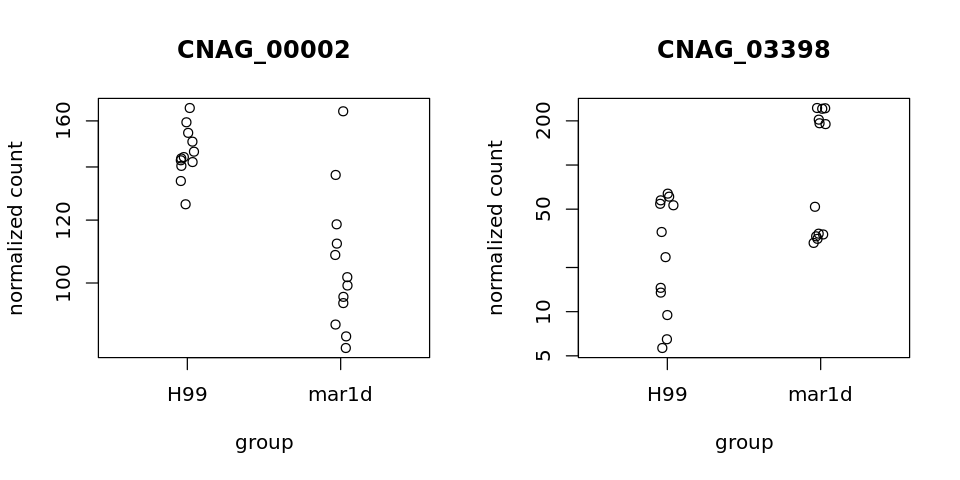

In [150]:
options(repr.plot.width = 8, repr.plot.height = 4)
par(mfrow = c(1, 2))
plotCounts(dds, 2,            intgroup = "Strain")
plotCounts(dds, "CNAG_03398", intgroup = "Strain")
par(mfrow = c(1, 1))

In [151]:
results(ddsDE, contrast = c("Media", "YPD", "TC"), tidy = TRUE) %>%
    arrange(padj) %>% 
    head(4)

row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
CNAG_03398,79.8140,-2.608085,0.1426368,-18.28479,1.093787e-74,8.714201e-71
CNAG_12988,115.7888,3.023987,0.1716819,17.61389,1.927318e-69,7.677472e-66
CNAG_00183,752.6948,1.743143,0.1124465,15.50197,3.364131e-54,8.934011e-51
CNAG_02083,484.1644,4.382439,0.2886512,15.18247,4.620316e-52,9.202514e-49


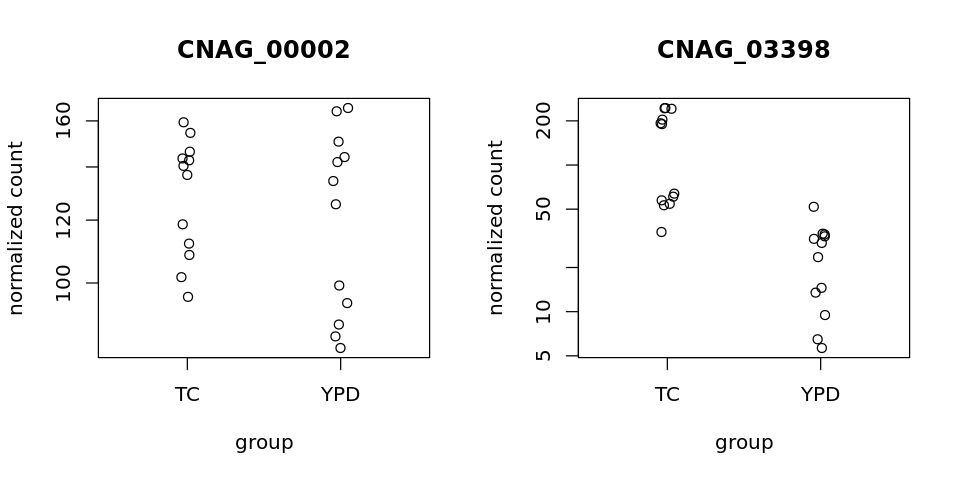

In [152]:
options(repr.plot.width = 8, repr.plot.height = 4)
par(mfrow = c(1, 2))
plotCounts(dds, 2,            intgroup = "Media")
plotCounts(dds, "CNAG_03398", intgroup = "Media")
par(mfrow = c(1, 1))

#  FPM
Another approach is to FPM: fragments per million mapped fragments

In [153]:
head(fpm(dds), 3)

,1_RZ_J,10_RZ_C,11_RZ_J,12_RZ_P,13_RZ_J,14_RZ_C,15_RZ_C,16_RZ_P,2_RZ_C,21_RZ_C,⋯,27_RZ_P,3_RZ_J,35_RZ_P,36_RZ_J,38_RZ_P,4_RZ_P,40_RZ_J,45_RZ_P,47_RZ_P,9_RZ_C
CNAG_00001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.1714117,0.000000,0.000000,⋯,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
CNAG_00002,20.901462,13.062869,11.459694,12.271331,21.442114,19.904350,19.478103,22.1121141,19.984718,14.088476,⋯,19.696805,17.419415,22.830625,13.74964,19.798140,23.050408,20.30028,18.971479,16.432087,11.854334
CNAG_00003,4.098326,4.125116,2.242114,6.519145,5.220689,5.796322,5.259088,6.8564695,4.758266,4.658286,⋯,4.122587,3.907159,3.957308,5.42417,8.961263,4.971657,4.57836,7.153181,6.015318,3.914167


Let's calculate the FPM manually. For gene $i$ sample $j$, the FPM is defined as $\frac{K_{ij}}{D_j}\times 10^{6}$ where $D_j=\sum_{i=1} K_{ij}$ is the read depth for sample $j$. First get the read depth for each sample

In [154]:
D <- colSums(counts(dds)) # colSums: sum of each column, where each column represents a sample
D

1_RZ_J  10_RZ_C  11_RZ_J  12_RZ_P  13_RZ_J  14_RZ_C  15_RZ_C  16_RZ_P 
 9475228  5225990  7372861  9424584  7694026  6072600  6878021  5381493 
  2_RZ_C  21_RZ_C  22_RZ_C  23_RZ_J  24_RZ_J  26_RZ_C  27_RZ_P   3_RZ_J 
 7968580  5576844  9674841  7430971  5618403 10234827  5365313  6086446 
 35_RZ_P  36_RZ_J  38_RZ_P   4_RZ_P  40_RZ_J  45_RZ_P  47_RZ_P   9_RZ_C 
 5470593  8613592  4818290 12634911  8494294  7227953  7038105  8067172

By default, the fpm() function uses a robust approach. We will disable this right now as to replicate the standard FPM. Let's look at gene 1

In [155]:
fpm1 <- fpm(dds, robust = FALSE)[1,]
fpm1

1_RZ_J   10_RZ_C   11_RZ_J   12_RZ_P   13_RZ_J   14_RZ_C   15_RZ_C   16_RZ_P 
0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.1858220 
   2_RZ_C   21_RZ_C   22_RZ_C   23_RZ_J   24_RZ_J   26_RZ_C   27_RZ_P    3_RZ_J 
0.0000000 0.0000000 0.1033609 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 
  35_RZ_P   36_RZ_J   38_RZ_P    4_RZ_P   40_RZ_J   45_RZ_P   47_RZ_P    9_RZ_C 
0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000

Now get the raw counts for gene 1

In [156]:
cnt1 <- counts(dds)[1,]
cnt1

1_RZ_J 10_RZ_C 11_RZ_J 12_RZ_P 13_RZ_J 14_RZ_C 15_RZ_C 16_RZ_P  2_RZ_C 21_RZ_C 
      0       0       0       0       0       0       0       1       0       0 
22_RZ_C 23_RZ_J 24_RZ_J 26_RZ_C 27_RZ_P  3_RZ_J 35_RZ_P 36_RZ_J 38_RZ_P  4_RZ_P 
      1       0       0       0       0       0       0       0       0       0 
40_RZ_J 45_RZ_P 47_RZ_P  9_RZ_C 
      0       0       0       0

 Now calculate the FPM for gene 1

In [157]:
myfpm1 <- cnt1 / D * 1e6
myfpm1

1_RZ_J   10_RZ_C   11_RZ_J   12_RZ_P   13_RZ_J   14_RZ_C   15_RZ_C   16_RZ_P 
0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.1858220 
   2_RZ_C   21_RZ_C   22_RZ_C   23_RZ_J   24_RZ_J   26_RZ_C   27_RZ_P    3_RZ_J 
0.0000000 0.0000000 0.1033609 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 
  35_RZ_P   36_RZ_J   38_RZ_P    4_RZ_P   40_RZ_J   45_RZ_P   47_RZ_P    9_RZ_C 
0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000

Let's summarize what we have done:

In [158]:
tmp <- bind_rows(D, cnt1, myfpm1, fpm1)
tmp <- t(tmp)
colnames(tmp) <- c("col_sums", "count_gene1", "FPM_gene1_manual", "FPM_gene1_DESeq")
tmp

,col_sums,count_gene1,FPM_gene1_manual,FPM_gene1_DESeq
1_RZ_J,9475228,0,0.0000000,0.0000000
10_RZ_C,5225990,0,0.0000000,0.0000000
11_RZ_J,7372861,0,0.0000000,0.0000000
12_RZ_P,9424584,0,0.0000000,0.0000000
13_RZ_J,7694026,0,0.0000000,0.0000000
14_RZ_C,6072600,0,0.0000000,0.0000000
15_RZ_C,6878021,0,0.0000000,0.0000000
16_RZ_P,5381493,1,0.1858220,0.1858220
2_RZ_C,7968580,0,0.0000000,0.0000000
21_RZ_C,5576844,0,0.0000000,0.0000000


This is how you check if two numeric columns are "equal"? One approach is to calculate the maximum absoute difference

In [159]:
max(abs(fpm1 - myfpm1))

[1] 0

The above approach is also helpful in establishing if the difference is "small". Another approach to test for equality to use the all.equal() function

In [160]:
all.equal(fpm1, myfpm1)

[1] TRUE

 It is generally a bad idea to compare numeric vectors using == (e.g., fpm1==myfpm1)

### FPKM

 To calculate the FPKM (fragments per kilobase per million mapped fragments) we need to add annotation to assign the feature lengths. More specifically, for gene $i$ sample $j$, the FPKM is defined as $\frac{K_{ij}}{\ell_i D_j}\times 10^3 \times 10^{6}$ where $\ell_i$ is the "length" of gene $i$ (fragments for each $10^3$ bases in the gene for every  $\frac{D_j}{10^6}$ fragments. More on this later.

# Regularized log transformation
The regularized log transform can be obtained using the [rlog() function](https://rdrr.io/bioc/DESeq2/man/rlog.html). Note that an important argument for this function is blind (TRUE by default). The default "blinds" the normalization to the design. This is very important so as to not bias the analyses (e.g. class discovery) 

In [161]:
rld <- rlog(dds, blind = TRUE)

## Dendrogram of samples: showing strain & media of each sample

Hierarchical clustering using rlog transformation

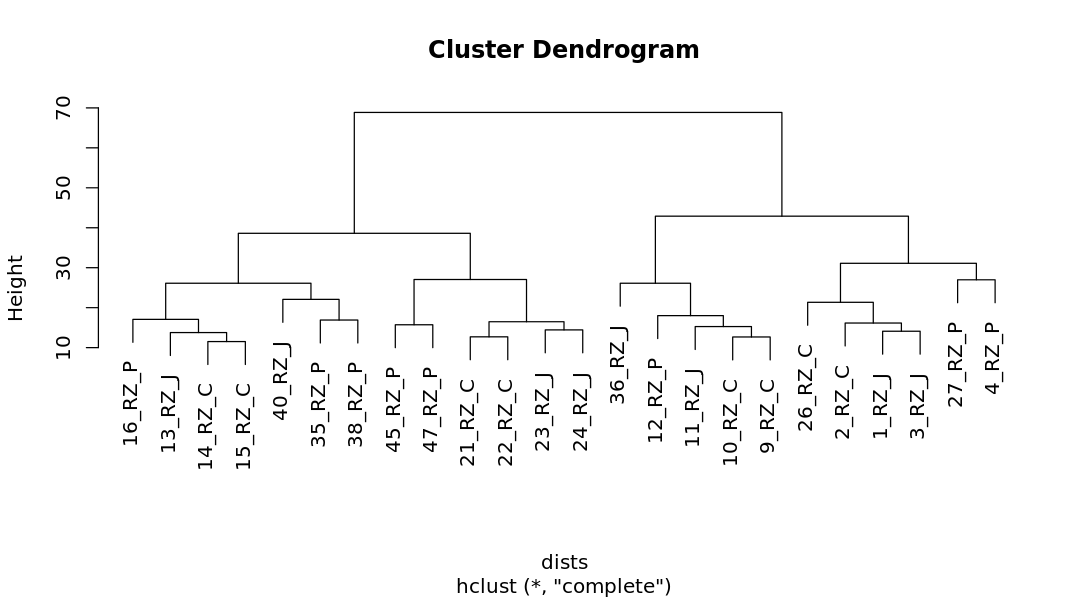

In [162]:
options(repr.plot.width = 9, repr.plot.height = 5)
dists <- dist(t(assay(rld)))
plot(hclust(dists)) 

Store the dendrogram of samples using hierarchical clustering

In [163]:
assay(rld) %>%
    t() %>%
    dist %>%
    hclust(method = "complete") %>%
    as.dendrogram ->
    mydend

Dendrogram of samples: showing strain of each sample

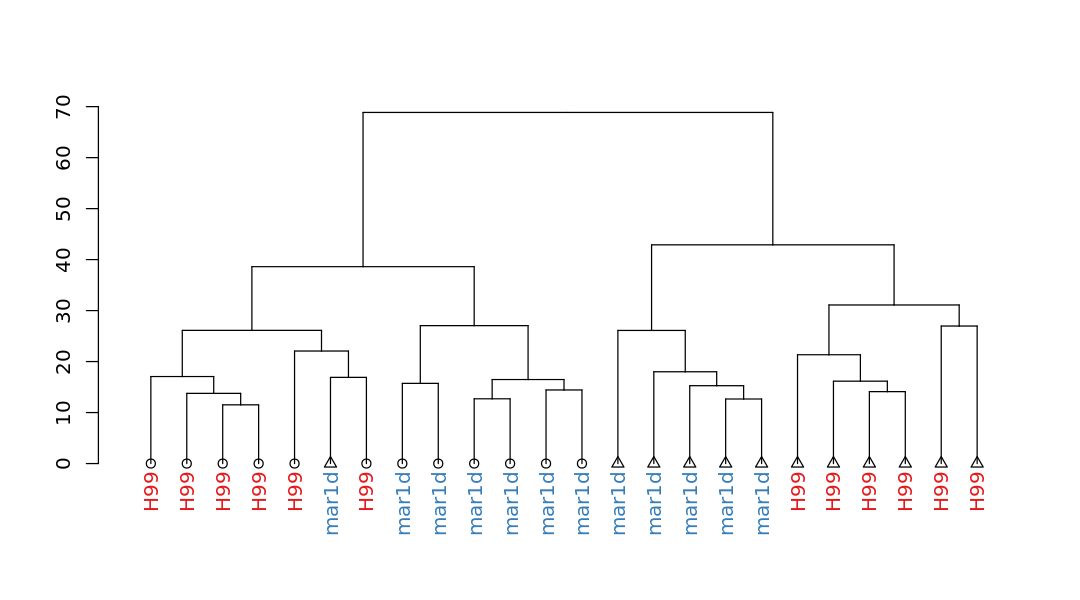

In [164]:
options(repr.plot.width = 9, repr.plot.height = 5)
dendplot(mydend, columnData, 
         "Strain",    # variable that show in label
         "Strain",    # variable that define color
         "Media") %>% # variable that define shape of points
    plot

Dendrogram of samples: showing media of each sample

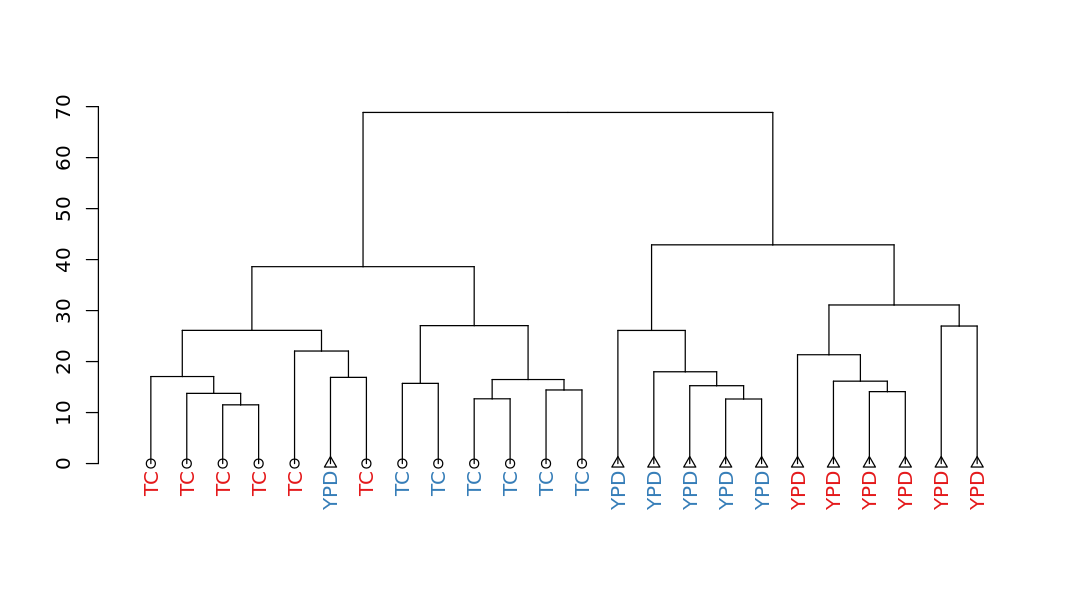

In [165]:
dendplot(mydend, columnData, "Media", "Strain", "Media") %>% plot

Dendrogram of samples: showing sample label

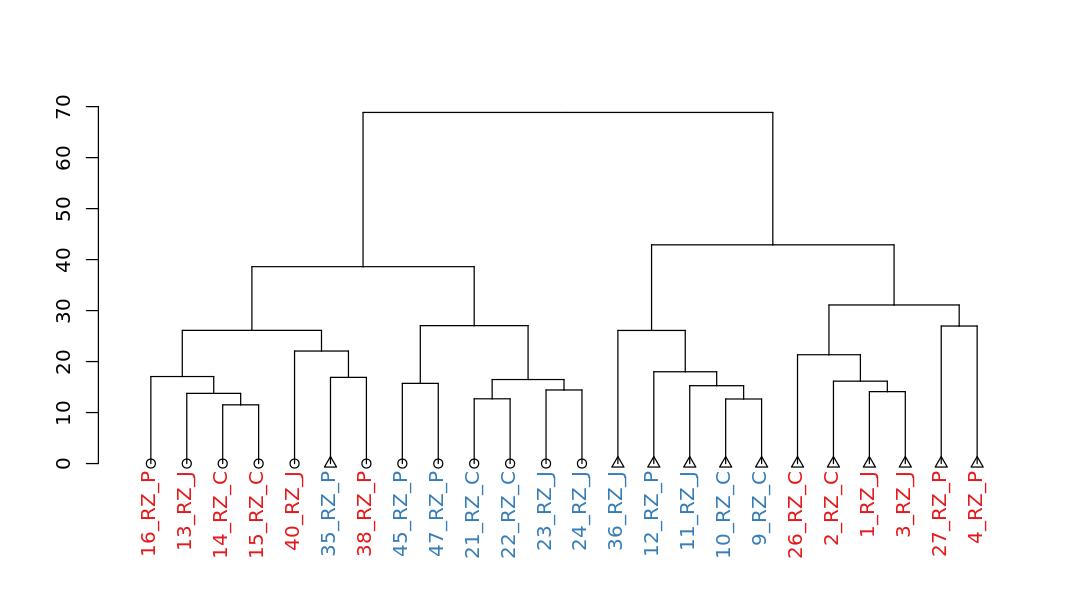

In [166]:
dendplot(mydend, columnData, "Label", "Strain", "Media") %>% plot

PC Analysis using the rlog transformation

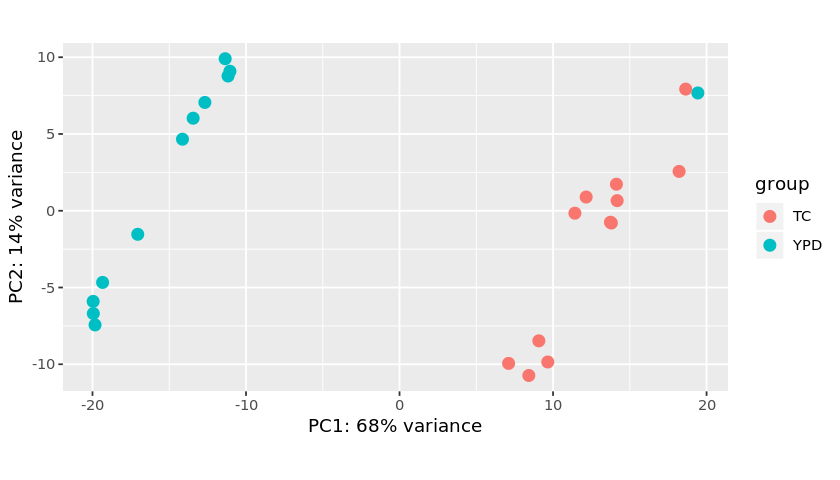

In [167]:
options(repr.plot.width = 7, repr.plot.height = 4)
plotPCA(rld, intgroup = "Media")

Store the plot into a pdf

In [168]:
pdf(file.path(IMGDIR, "dendrogram.pdf"))
dendplot(mydend, columnData, "Strain", "Strain", "Media") %>% plot
dendplot(mydend, columnData, "Media", "Strain", "Media") %>% plot
dendplot(mydend, columnData, "Label", "Strain", "Media") %>% plot
graphics.off()

# Variance Stabilizing Transformation (vst) and mean-variance modelling at the observational level (voom)

 Two other normalization approaches for RNA-Seq count data are provided by the functions DESeq2::vst and limma::voom (note that for the latter one needs the limma package).From ? DESeq2::vst
"This function calculates a variance stabilizing transformation (VST) from the fitted dispersion-mean relation(s) and then transforms the count data (normalized by division by the size factors or normalization factors), yielding a matrix of values which are now approximately homoskedastic (having constant variance along the range of mean values). The transformation also normalizes with respect to library size."Compared to DESeq2::rlog
"The ‘rlog’ is less sensitive to size factors, which can be an issue when size factors vary widely. These transformations are useful when checking for outliers or as input for machine learning techniques such as clustering or linear discriminant analysis."From ? limma::voom
"Transform count data to log2-counts per million (logCPM), estimate the mean-variance relationship and use this to compute appropriate observation-level weights. The data are then ready for linear modelling." Get VST transformation

In [169]:
VST <- vst(dds)
class(VST)

[1] "DESeqTransform"
attr(,"package")
[1] "DESeq2"

Get the VST matrix

In [170]:
VSTmat <- assay(VST)
dim(VSTmat)
VSTmat[1:10,]

[1] 8497   24

,1_RZ_J,10_RZ_C,11_RZ_J,12_RZ_P,13_RZ_J,14_RZ_C,15_RZ_C,16_RZ_P,2_RZ_C,21_RZ_C,⋯,27_RZ_P,3_RZ_J,35_RZ_P,36_RZ_J,38_RZ_P,4_RZ_P,40_RZ_J,45_RZ_P,47_RZ_P,9_RZ_C
CNAG_00001,2.073038,2.073038,2.073038,2.073038,2.073038,2.073038,2.073038,2.844284,2.073038,2.073038,⋯,2.073038,2.073038,2.073038,2.073038,2.073038,2.073038,2.073038,2.073038,2.073038,2.073038
CNAG_00002,7.307957,6.673620,6.500569,6.590781,7.342916,7.241168,7.211645,7.385095,7.246668,6.774314,⋯,7.226869,7.059856,7.428996,6.741821,7.233868,7.442162,7.268060,7.175749,6.980962,6.545140
CNAG_00003,5.224344,5.231846,4.571555,5.779419,5.508795,5.635159,5.517584,5.842050,5.398441,5.373407,⋯,5.231140,5.169613,5.184178,5.554759,6.180871,5.450436,5.353070,5.894957,5.680429,5.171658
CNAG_00004,7.327936,7.511128,7.396494,7.802302,8.095737,8.197471,8.225972,8.327048,7.371125,8.038955,⋯,7.589485,7.426655,7.984543,7.580267,8.004903,7.414955,8.142860,8.099227,8.230315,7.617071
CNAG_00005,6.647388,5.279052,5.192438,4.597741,7.158939,7.218497,7.120205,7.330916,6.802973,6.752604,⋯,6.332550,6.435784,7.465176,5.879266,7.033926,6.482041,7.458369,6.625320,7.051509,5.325893
CNAG_00006,9.909267,10.301145,10.223828,10.326330,9.595996,9.449128,9.548082,9.589901,9.836437,9.827626,⋯,10.364245,9.930142,9.904755,10.739232,9.887376,10.028128,9.908365,10.259825,10.230639,10.253532
CNAG_00007,9.475844,9.702554,9.642834,9.950024,8.486375,8.499511,8.572056,8.807317,9.531200,8.578164,⋯,9.792811,9.443094,8.171277,9.714743,8.480584,9.668222,8.315820,8.861962,8.705012,9.600738
CNAG_00008,8.938087,8.783145,8.609059,8.479207,8.867723,9.024129,9.080850,8.795370,9.032569,9.040775,⋯,8.757807,8.905984,8.782267,8.659578,8.985636,8.307499,8.853743,8.723926,8.755147,8.565051
CNAG_00009,8.252598,7.641807,7.649028,7.495834,7.841405,7.814938,7.855029,7.690601,8.231802,7.979528,⋯,7.918756,8.298180,7.568565,7.679306,7.531241,7.919575,7.552036,7.870361,7.876195,7.634683
CNAG_00010,8.210191,8.958114,8.780339,9.009210,8.735679,8.982157,8.931729,9.151459,8.466029,8.749388,⋯,8.426330,8.426343,8.393988,8.777492,8.602302,8.307499,8.698604,8.528256,8.857048,8.884915


Get voom transformation (note that according to ? limma::voom, the function is expecting raw counts

In [171]:
VOOM <- limma::voom(counts(dds))

Get the VOOM matrix

In [172]:
VOOMmat <- VOOM$E
dim(VOOMmat)
VOOMmat[1:10,]

[1] 8497   24

,1_RZ_J,10_RZ_C,11_RZ_J,12_RZ_P,13_RZ_J,14_RZ_C,15_RZ_C,16_RZ_P,2_RZ_C,21_RZ_C,⋯,27_RZ_P,3_RZ_J,35_RZ_P,36_RZ_J,38_RZ_P,4_RZ_P,40_RZ_J,45_RZ_P,47_RZ_P,9_RZ_C
CNAG_00001,-4.244161,-3.385705,-3.882225,-4.2364291,-3.943739,-3.602315,-3.781994,-1.843044,-3.994323,-3.479449,⋯,-3.4236626,-3.605600,-3.451697,-4.106615,-3.268522,-4.6593437,-4.086494,-3.853587,-3.815187,-4.012063
CNAG_00002,4.431796,3.871683,3.649157,2.7747982,4.904884,4.909438,4.865465,4.588802,4.402282,4.480553,⋯,3.0192809,4.142593,4.781922,3.668172,4.308907,2.0271568,4.793089,4.083051,3.998594,3.722646
CNAG_00003,2.095689,2.229005,1.327229,1.8720954,2.876440,3.139152,2.986191,2.911843,2.345527,2.895590,⋯,0.8242649,2.009110,2.276223,2.336328,3.174422,-0.1357818,2.654973,2.685571,2.559852,2.137684
CNAG_00004,4.452807,4.758954,4.605615,4.0535898,5.687438,5.903497,5.920179,5.563515,4.533154,5.808263,⋯,3.3965164,4.528826,5.358874,4.555163,5.110857,1.9988678,5.703039,5.044258,5.301157,4.861381
CNAG_00005,3.727383,2.286721,2.140143,0.4074271,4.710897,4.885525,4.768753,4.531995,3.930490,4.457189,⋯,2.0681905,3.471215,4.819766,2.713564,4.097801,1.0130816,4.992991,3.495141,4.073556,2.327787
CNAG_00006,7.095132,7.602270,7.492271,6.6192181,7.215502,7.178225,7.265812,6.846954,7.056206,7.628422,⋯,6.2147733,7.087015,7.312345,7.767982,7.024950,4.6603284,7.497999,7.237187,7.330108,7.547792
CNAG_00007,6.657460,6.999079,6.906494,6.2403171,6.088307,6.213069,6.274644,6.053793,6.747987,6.361329,⋯,5.6397325,6.595298,5.551118,6.736521,5.598757,4.2977583,5.880732,5.824132,5.786584,6.889558
CNAG_00008,6.112291,6.067566,5.857556,4.7494128,6.477274,6.747520,6.792600,6.041635,6.242887,6.832299,⋯,4.5931457,6.050825,6.175836,5.666524,6.113021,2.9180851,6.430191,5.683631,5.837658,5.838124
CNAG_00009,5.412264,4.895066,4.869319,3.7351145,5.424768,5.508821,5.537678,4.907384,5.425637,5.746963,⋯,3.7362087,5.430573,4.927681,4.658256,4.620222,2.5205654,5.090925,4.808191,4.936357,4.879721
CNAG_00010,5.368708,6.245472,6.032160,5.2890917,6.342819,6.704886,6.641122,6.403300,5.665673,6.535966,⋯,4.2558175,5.561818,5.779524,5.786686,5.723000,2.9180851,6.272157,5.484035,5.941369,6.164110


# Appendix: Multiplicitive Model

In [173]:
### Make DESeq object on the basis of the counts
dds_mult <- DESeqDataSetFromMatrix(countData, columnData, ~ Media + Strain + Media:Strain)
### Estimate Size Factors
dds_mult <- estimateSizeFactors(dds_mult)
### Estimate Dispersion parameters (for each gene)
dds_mult <- estimateDispersions(dds_mult)
### Fit NB MLE model
dds_mult <- DESeq(dds_mult)
### Rlog "normalized" expressions
rld <- rlog(dds_mult)

gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


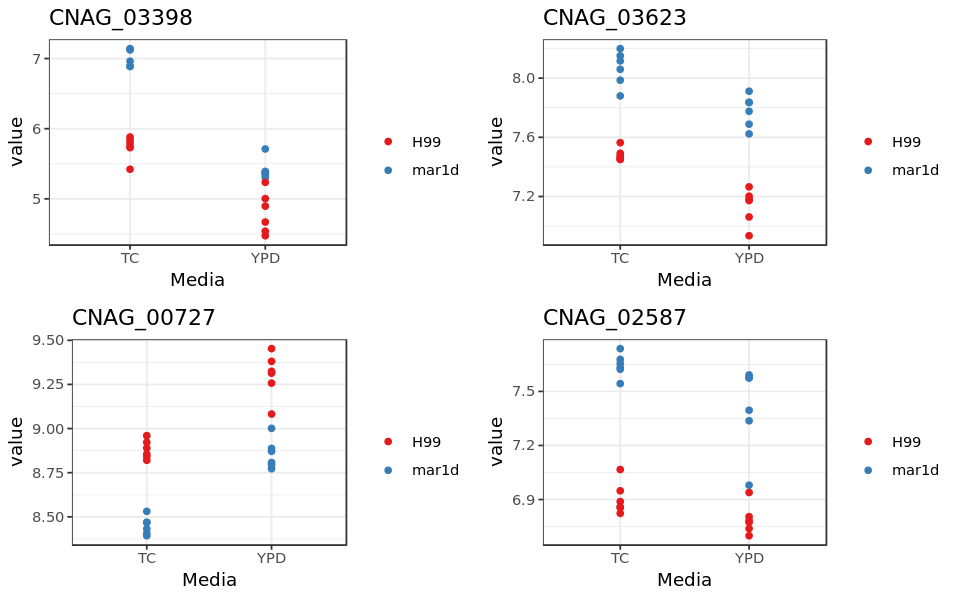

In [174]:
options(repr.plot.width = 8, repr.plot.height = 5)
grid.arrange(
    myinteractplot(rld, "CNAG_03398", "Strain"),
    myinteractplot(rld, "CNAG_03623", "Strain"),
    myinteractplot(rld, "CNAG_00727", "Strain"),
    myinteractplot(rld, "CNAG_02587", "Strain"),
    ncol=2)

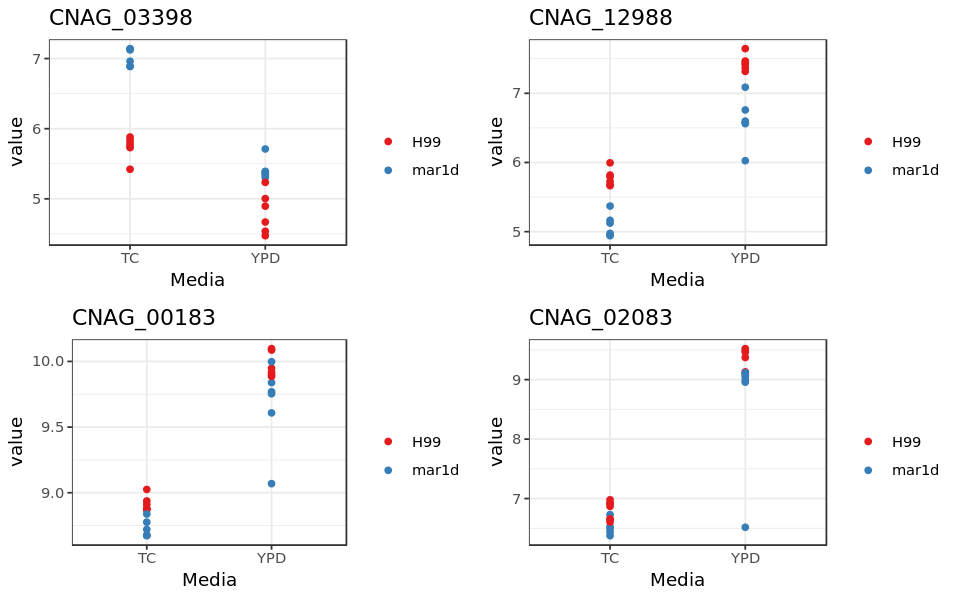

In [175]:
options(repr.plot.width = 8, repr.plot.height = 5)
grid.arrange(
    myinteractplot(rld, "CNAG_03398", "media"),
    myinteractplot(rld, "CNAG_12988", "media"),
    myinteractplot(rld, "CNAG_00183", "media"),
    myinteractplot(rld, "CNAG_02083", "media"),
    ncol=2)

# Appendix: Get Session Information

In [176]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 8 (jessie)

Matrix products: default
BLAS: /opt/conda/lib/R/lib/libRblas.so
LAPACK: /opt/conda/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] tools     parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2               dendextend_1.8.0          
 [3] gridExtra_2.3              RColorBrewer_1.1-2        
 [5] qvalue_2.10.0              limma_3.34.9              
 [7] DESeq2_1.18.1              SummarizedExperiment_1.8.0
 [9] DelayedArray_0.4